# Tutorial 2: Indexing assemblies (SARS-CoV-2 dataset)

# 1. Background

This tutorial shows you how to construct an index of assembled genomes for querying and visualization. The data consists of a set of 50 SARS-CoV-2 genomes downloaded from the NCBI Virus portal (https://www.ncbi.nlm.nih.gov/labs/virus/) on May 31, 2021.

# 2. Getting data

Let's first download the data for this tutorial. To do this please run the below commands:

*Note: In a Jupyter Python notebook, prepending a command with `!` runs the command in a shell instead of the Python interpreter (e.g., `!unzip` runs the command `unzip`).*

In [80]:
!wget -O sars-cov-2-genbank-50.zip https://ndownloader.figshare.com/files/28258689?private_link=e54aded21bb036071aac
!unzip -n sars-cov-2-genbank-50.zip | head -n 3

--2021-06-01 15:11:09--  https://ndownloader.figshare.com/files/28258689?private_link=e54aded21bb036071aac
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 34.246.37.135, 52.18.39.136, 52.214.160.144, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|34.246.37.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 475135 (464K) [application/zip]
Saving to: ‘sars-cov-2-genbank-50.zip’

sars-cov-2-genbank- 100%[===================>] 464.00K   758KB/s    in 0.6s    

2021-06-01 15:11:11 (758 KB/s) - ‘sars-cov-2-genbank-50.zip’ saved [475135/475135]

Archive:  sars-cov-2-genbank-50.zip
   creating: sars-cov-2-genbank-50/
   creating: sars-cov-2-genbank-50/fasta/


## 2.1. Examine data

Let's look at what files are available in this dataset.

In [81]:
!ls -F sars-cov-2-genbank-50

fasta/	reference/  sars-cov-2.metadata.csv  tree.newick


There is a file of metadata `sars-cov-2.metadata.csv` (from NCBI) which looks like:

In [20]:
import pandas as pd
pd.read_csv('sars-cov-2-genbank-50/sars-cov-2.metadata.csv').head(2)

,Accession,Submitters,Release_Date,Pangolin,Species,Molecule_type,Length,Sequence_Type,Genotype,Geo_Location,USA,Host,Isolation_Source,Collection_Date,BioSample
0,MW023498.1,"Schmedes,S., Blanton,J.",2020-09-21T00:00:00Z,A,Severe acute respiratory syndrome-related coro...,ssRNA(+),29812,GenBank,NaN,USA: FL,FL,Homo sapiens,NaN,2020-03-30,NaN
1,MT704130.1,"Keller,E.",2020-07-02T00:00:00Z,A,Severe acute respiratory syndrome-related coro...,ssRNA(+),29873,GenBank,NaN,USA: MD,MD,Homo sapiens,oronasopharynx,2020-04-07,NaN


There's a reference genome in the `reference/` directory:

In [21]:
!ls sars-cov-2-genbank-1000/reference

ls: cannot access 'sars-cov-2-genbank-1000/reference': No such file or directory


And, there are the input SARS-CoV-2 genomes in the `fasta/` directory, one genome per file:

In [22]:
!ls sars-cov-2-genbank-50/fasta | head

FR989650.1.fasta
FR990962.1.fasta
FR993910.1.fasta
FR995660.1.fasta
FR996003.1.fasta
FR996164.1.fasta
FR999475.1.fasta
HG997074.1.fasta
MT292574.1.fasta
MT375477.1.fasta


Now that we've seen the input data, let's go through generating an index.

# 3. Create an index

## 3.1. Initialize an index

We first use the command `gdi init [project]` to construct an project/index directory where we can then load up data.

In [23]:
!gdi init sars-cov-2-index

Initializing empty project in [sars-cov-2-index]


This will create a directory `sars-cov-2-index` which contains the empty index. If we look inside this directory we can see:

In [24]:
!ls -a sars-cov-2-index

.  ..  gdi-config.yaml	.gdi-data


We see a config file `gdi-config.yaml` which defines some configuration settings:

In [25]:
!cat sars-cov-2-index/gdi-config.yaml

database_dir: .gdi-data
sqlite_database: .gdi-data/gdi-db.sqlite


Specifically, this file defines the data directory which is used to store VCF/mash/other files. As well as a SQLite database connection path.

The `.gdi-data` directory will initially be empty, but will be filled with data as we load data into the index.

## 3.2. Index mutations and kmers

To index assembled genomes we can use the command `gdi --project-dir sars-cov-2-index analysis assembly [...]`.

The project directory must be specified with `--project-dir`. Or, alternatively, you can `cd sars-cov-2-index` and then run `gdi analysis assembly [...]` and leave out the `--project-dir`.

Indexing will align the assembled genomes to some reference genome using [minimap2](https://github.com/lh3/minimap2) (for identifying mutations in VCF format) and will also run [sourmash](https://sourmash.readthedocs.io/) for construcing kmer sketches. This is all scheduled using a [Snakemake](https://snakemake.readthedocs.io/) workflow.

In [26]:
!gdi --project-dir sars-cov-2-index analysis assembly \
    --reference-file sars-cov-2-genbank-50/reference/MN996528.1-ref.fasta \
    --use-conda \
    --include-kmer \
    --kmer-size 21 --kmer-size 31 --kmer-size 51 \
    --kmer-scaled 100 \
    sars-cov-2-genbank-50/fasta/*.fasta

2021-06-01 14:14:57 INFO: Processing 50 genomes to identify mutations
2021-06-01 14:14:57 INFO: Running Snakemake for rule all
2021-06-01 14:16:42 INFO: Finished running snakemake.
2021-06-01 14:16:42 INFO: Indexing processed VCF files defined in [/home/CSCScience.ca/apetkau/workspace/thesis-index/docs/tutorial/snakemake-assemblies.1622574897.3560145/gdi-input.fofn]
Loading files listed in /home/CSCScience.ca/apetkau/workspace/thesis-index/docs/tutorial/snakemake-assemblies.1622574897.3560145/gdi-input.fofn
2021-06-01 14:16:42 INFO: Proccessed 0% (0/50) samples
2021-06-01 14:16:42 INFO: Proccessed 10% (5/50) samples
2021-06-01 14:16:42 INFO: Proccessed 20% (10/50) samples
2021-06-01 14:16:42 INFO: Proccessed 30% (15/50) samples
2021-06-01 14:16:42 INFO: Proccessed 40% (20/50) samples
2021-06-01 14:16:42 INFO: Proccessed 50% (25/50) samples
2021-06-01 14:16:42 INFO: Proccessed 60% (30/50) samples
2021-06-01 14:16:42 INFO: Proccessed 70% (35/50) samples
2021-06-01 14:16:42 INFO: Proccess

The different parameters are interpreted as follows:
    
* `--reference-file`: Path to the reference file used for alignment.
* `--use-conda`: Install workflow dependencies using conda
* `--include-kmer`: Include kmer (sourmash) sketches.
* `--kmer-size`: Specify the kmer-sizes for sourmash.
* `--kmer-scaled`: Specify the scaling factor for sourmash.
* `sars-cov-2-genbank-50/fasta/*.fasta.gz`: The input genomes to index (assembled genomes).

By default, this will use the maximum number of cores available on your machine for processing. This can be adjusted with `gdi --ncores [ncores]`.

Note, the slower part of this will likely be installing the tools using conda/mamba.

When everything is completed, the index directory `sars-cov-2-index/` should now have data within it.

In [27]:
!ls sars-cov-2-index/.gdi-data

gdi-db.sqlite  kmer  mlst  reference  variation


## 3.3. Build phylogenetic tree

In addition to indexing mutations or kmer sketches, a phylogenetic tree can be built and saved using all genomes aligned to some specific reference genome. This can be accomplished with the `gdi rebuild tree` command.

This command requires us to specify the reference genome name. This is derived from the file defined above, but to view all reference genome names you can use the `gdi list genomes` command.

In [28]:
!gdi --project-dir sars-cov-2-index list genomes

MN996528.1-ref


Now that we have a reference genome, let's build a tree. This uses [iqtree](http://www.iqtree.org/) by default.

*Note: if you wish you can skip this step and instead you can use the provided tree in `sars-cov-2-genbank-1000/tree.newick` when querying. You will have to remember to join a tree to a query with [query.join_tree()](https://github.com/apetkau/genomics-data-index/blob/development/genomics_data_index/api/query/SamplesQuery.py#L177-L188).*

In [29]:
!gdi --project-dir sars-cov-2-index/ rebuild tree --align-type full --extra-params '--fast -m GTR+F+R4' MN996528.1-ref

2021-06-01 14:16:50 INFO: Started rebuilding tree for reference genome [MN996528.1-ref]
2021-06-01 14:19:53 INFO: Finished rebuilding tree


The parameters are interpreted as follows:

* `--align-type full`: Use `full` to include all positions on the reference genome (29,903 bp in this case). Use `core` to include only core SNV-containing positions. Note that the tree is built using only SNVs (SNPs), indels or complex variants/mutations are excluded.
* `--extra-params`: Extra parameters to pass to `iqtree`. I am specifying the model here to speed up building a tree. Specifying extra parameters is optional.
* `MN996528.1-ref`: The name of the reference genome to use for building a tree.

Once everything is complete you can export the tree in newick format as follows:

In [30]:
!gdi --project-dir sars-cov-2-index export tree MN996528.1-ref

(FR989650.1:1.0147e-06,((((((((((FR990962.1:0.0003688,MW637368.1:0.000286577)1:1.0147e-06,MW672666.1:1.0147e-06)1:1.0147e-06,((((((FR995660.1:1.0147e-06,MT612123.1:6.78708e-05)1:1.0147e-06,MT292574.1:3.3934e-05)1:0.000168461,(((MT704130.1:7.38531e-05,MW023498.1:3.3934e-05)1:7.34086e-05,MW190745.1:0.000100765)1:0.000255784,(MW667352.1:0.000100663,MZ000016.1:0.000313142)1:0.000605558)1:1.0147e-06)1:2.0434e-06,(MT375477.1:0.000134641,(MT627305.1:1.0147e-06,MT633037.1:1.0147e-06)1:1.0147e-06)1:0.000100331)1:6.78708e-05,MW467468.1:0.000267724)1:1.0147e-06,MN996528.1-ref:1.0147e-06)1:0.00013439)1:1.0147e-06,((FR993910.1:1.0147e-06,OB983396.1:0.000474786)1:1.0147e-06,(FR996164.1:6.78708e-05,FR999475.1:0.000168619)1:1.0147e-06)1:1.0147e-06)1:1.0147e-06,(((FR996003.1:3.3934e-05,HG997074.1:0.000256725)1:3.39339e-05,(MW436729.1:0.000109676,MW750847.1:0.000335439)1:3.39339e-05)1:3.39339e-05,(MW922928.1:1.0147e-06,(OA980698.1:0.00013429,OA981378.1:6.78708e-05)1:3.39339e-05)1:1.0147e-06)1:1.0147e-06

# 4. Basic querying/visualization

Once you have the index setup you can do some basic querying as follows.

I include this here to show a complete tutorial of both indexing and working with data. For an additional querying tutorial please see [Tutorial 1](https://github.com/apetkau/genomics-data-index/blob/development/docs/tutorial/tutorial-1-salmonella.ipynb).

## 4.1. Command-line interface

### 4.1.1. List samples

In [31]:
!gdi --project-dir sars-cov-2-index list samples | head

FR996003.1
MW780412.1
MW493710.1
MW422101.1
FR993910.1
MZ000016.1
MT612123.1
MW922928.1
OA972232.1
MT627305.1


### 4.1.2. Related samples based on shared kmers in sketchs

In [34]:
!gdi --project-dir sars-cov-2-index query sample-kmer FR996003.1 | head -n 3 | column -s$'\t' -t

Type  Query       Match       Similarity  Distance
kmer  FR996003.1  FR996003.1  1           0
kmer  FR996003.1  FR993910.1  0.9928      0.007168


### 4.1.3. Related samples based on shared mutations (based on distances in phylogenetic tree)

In [33]:
!gdi --project-dir sars-cov-2-index query sample-mutation FR996003.1 | head -n 3 | column -s$'\t' -t

Type      Reference Genome  Query       Match       Distance  Distance (subs/site)  SNV Alignment Length
mutation  MN996528.1-ref    FR996003.1  MW922928.1  3.1       0.0001038             29903
mutation  MN996528.1-ref    FR996003.1  MW672666.1  3.2       0.0001069             29903


### 4.1.4. Samples that contain a mutation

In [36]:
!gdi --project-dir sars-cov-2-index query mutation 'MN996528.1:23403:A:G' | head -n 3 | column -s$'\t' -t

Type      Feature               Sample Name  Sample ID  Status
mutation  MN996528.1:23403:A:G  FR989650.1   12         Present
mutation  MN996528.1:23403:A:G  FR990962.1   20         Present


## 4.2. Python API

First lets connect to the index in the directory `sars-cov-2-index`.

In [37]:
import genomics_data_index.api as gdi

db = gdi.GenomicsDataIndex.connect('sars-cov-2-index')
db

<GenomicsDataIndex(samples=50)>

Now let's load up the dataframe of provided metadata.

In [40]:
import pandas as pd

metadata_df = pd.read_csv('sars-cov-2-genbank-50/sars-cov-2.metadata.csv')
metadata_df.head(3)

,Accession,Submitters,Release_Date,Pangolin,Species,Molecule_type,Length,Sequence_Type,Genotype,Geo_Location,USA,Host,Isolation_Source,Collection_Date,BioSample
0,MW023498.1,"Schmedes,S., Blanton,J.",2020-09-21T00:00:00Z,A,Severe acute respiratory syndrome-related coro...,ssRNA(+),29812,GenBank,NaN,USA: FL,FL,Homo sapiens,NaN,2020-03-30,NaN
1,MT704130.1,"Keller,E.",2020-07-02T00:00:00Z,A,Severe acute respiratory syndrome-related coro...,ssRNA(+),29873,GenBank,NaN,USA: MD,MD,Homo sapiens,oronasopharynx,2020-04-07,NaN
2,MT627305.1,"Nickerson,D.A., Frazar,C.D., Lee,J., Pelle,B.,...",2020-06-17T00:00:00Z,A.1,Severe acute respiratory syndrome-related coro...,ssRNA(+),29862,GenBank,NaN,"USA: Washington,King County",WA,Homo sapiens,NaN,2020-03-02,NaN


### 4.2.1. Create query which includes tree

To create a query which includes a phylogenetic tree you will have to specify the reference genome.

In [41]:
q = db.samples_query(universe='mutations', reference_name='MN996528.1-ref')
q

<MutationTreeSamplesQuery[100% (50/50) samples]>

### 4.2.2. Create query and join tree from file

Alternatively, you can create a query and join to a tree stored in a separate file or some other external resource.

First you have to load the tree using the **ETEToolkit**.

In [42]:
from ete3 import Tree

tree = Tree('sars-cov-2-genbank-50/tree.newick')
tree

Tree node '' (0x7f359c8a9c7)

Now we join this tree to a query. You have to specify the alignment length used to construct the tree (in this case the same as the length of the reference genome). This is so that I can do conversions between distance units (**substitutions/site** to **substitutions**).

*Note: This may not quite be working 100% yet. This is still in-development software.*

In [47]:
q = db.samples_query().join_tree(tree, alignment_length=29903)
q

<MutationTreeSamplesQuery[100% (50/50) samples]>

### 4.2.3. Create query with tree and dataframe of metadata

To create a query with both the metadata and a tree attached we can do the following.

In [49]:
q = db.samples_query(universe='mutations', reference_name='MN996528.1-ref').join(metadata_df, sample_names_column='Accession')
q

<MutationTreeSamplesQuery[100% (50/50) samples]>

### 4.2.4. Show summary of mutations

In [50]:
q.summary_features()

,Sequence,Position,Deletion,Insertion,Count
Mutation,,,,,
MN996528.1:203:C:T,MN996528.1,203,C,T,1
MN996528.1:241:C:T,MN996528.1,241,C,T,38
MN996528.1:490:T:A,MN996528.1,490,T,A,3
MN996528.1:593:C:T,MN996528.1,593,C,T,1
MN996528.1:704:G:A,MN996528.1,704,G,A,1
...,...,...,...,...,...
MN996528.1:29737:GCCACGCGGAGTACGATCGAGTGT:G,MN996528.1,29737,GCCACGCGGAGTACGATCGAGTGT,G,1
MN996528.1:29742:G:A,MN996528.1,29742,G,A,2
MN996528.1:29762:C:T,MN996528.1,29762,C,T,1


### 4.2.5. Find genomes with a particular mutation

In [52]:
q.hasa('MN996528.1:29771:A:G').toframe()

,Query,Sample Name,Sample ID,Status,Accession,Submitters,Release_Date,Pangolin,Species,Molecule_type,Length,Sequence_Type,Genotype,Geo_Location,USA,Host,Isolation_Source,Collection_Date,BioSample
0,dataframe(names_col=[Accession]) AND MN996528....,OD898064.1,15,Present,OD898064.1,"Howes,R., The Lighthouse Lab in,Cambridge., Al...",2021-04-23T00:00:00Z,AD.2,Severe acute respiratory syndrome-related coro...,ssRNA(+),29903,GenBank,NaN,United Kingdom:England,NaN,Homo sapiens,NaN,2020-11-12,SAMEA7673077
1,dataframe(names_col=[Accession]) AND MN996528....,OA992224.1,41,Present,OA992224.1,"Wynn,J., Hyland,M., The Lighthouse Lab in Alde...",2021-04-20T00:00:00Z,AD.2,Severe acute respiratory syndrome-related coro...,ssRNA(+),29903,GenBank,NaN,United Kingdom:England,NaN,Homo sapiens,NaN,2020-10-02,SAMEA7454619
2,dataframe(names_col=[Accession]) AND MN996528....,OA992920.1,21,Present,OA992920.1,"VanSteenhouse,H., Kasai,Y., Gray,D., Clugston,...",2021-04-20T00:00:00Z,AD.2,Severe acute respiratory syndrome-related coro...,ssRNA(+),29903,GenBank,NaN,United Kingdom:England,NaN,Homo sapiens,NaN,2020-09-23,SAMEA7454128
3,dataframe(names_col=[Accession]) AND MN996528....,OA994670.1,28,Present,OA994670.1,"VanSteenhouse,H., Kasai,Y., Gray,D., Clugston,...",2021-04-20T00:00:00Z,AD.2,Severe acute respiratory syndrome-related coro...,ssRNA(+),29903,GenBank,NaN,United Kingdom:England,NaN,Homo sapiens,NaN,2020-09-17,SAMEA7451889
4,dataframe(names_col=[Accession]) AND MN996528....,OA996868.1,45,Present,OA996868.1,"The Lighthouse Lab in Milton,Keynes., Alderton...",2021-04-20T00:00:00Z,AD.2,Severe acute respiratory syndrome-related coro...,ssRNA(+),29903,GenBank,NaN,United Kingdom:England,NaN,Homo sapiens,NaN,2020-10-06,SAMEA7493116
5,dataframe(names_col=[Accession]) AND MN996528....,OA997286.1,47,Present,OA997286.1,"VanSteenhouse,H., Kasai,Y., Gray,D., Clugston,...",2021-04-20T00:00:00Z,AD.2,Severe acute respiratory syndrome-related coro...,ssRNA(+),29903,GenBank,NaN,United Kingdom:England,NaN,Homo sapiens,NaN,2020-10-01,SAMEA7466485
6,dataframe(names_col=[Accession]) AND MN996528....,OA999333.1,48,Present,OA999333.1,"The Lighthouse Lab in Milton,Keynes., Alderton...",2021-04-20T00:00:00Z,AD.2,Severe acute respiratory syndrome-related coro...,ssRNA(+),29903,GenBank,NaN,United Kingdom:England,NaN,Homo sapiens,NaN,2020-09-19,SAMEA7377209
7,dataframe(names_col=[Accession]) AND MN996528....,OA969796.1,31,Present,OA969796.1,"VanSteenhouse,H., Kasai,Y., Gray,D., Clugston,...",2021-04-12T00:00:00Z,AD.2,Severe acute respiratory syndrome-related coro...,ssRNA(+),29903,GenBank,NaN,United Kingdom:Scotland,NaN,Homo sapiens,NaN,2020-08-09,SAMEA7315503
8,dataframe(names_col=[Accession]) AND MN996528....,OA972232.1,9,Present,OA972232.1,"The Lighthouse Lab in Milton,Keynes., Alderton...",2021-04-12T00:00:00Z,AD.2,Severe acute respiratory syndrome-related coro...,ssRNA(+),29903,GenBank,NaN,United Kingdom:England,NaN,Homo sapiens,NaN,2020-08-30,SAMEA7367585
9,dataframe(names_col=[Accession]) AND MN996528....,FR989650.1,12,Present,FR989650.1,"VanSteenhouse,H., Kasai,Y., Gray,D., Clugston,...",2021-03-30T00:00:00Z,AD.2,Severe acute respiratory syndrome-related coro...,ssRNA(+),29903,GenBank,NaN,United Kingdom:England,NaN,Homo sapiens,NaN,2020-08-29,SAMEA7317842


### 4.2.6. Visualize queries on tree

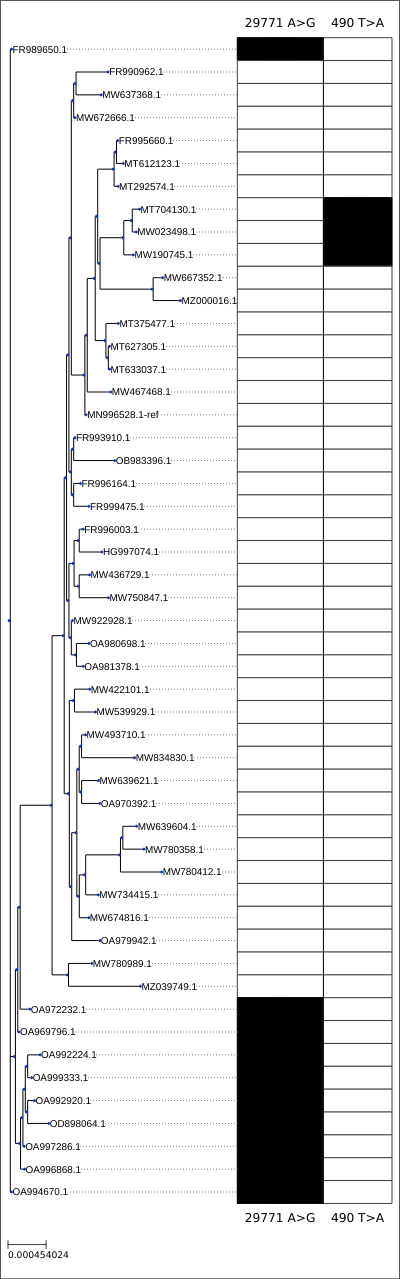

In [64]:
q.tree_styler()\
    .annotate(q.hasa('MN996528.1:29771:A:G'), label='29771 A>G')\
    .annotate(q.hasa('MN996528.1:490:T:A'), label='490 T>A')\
    .render(w=400)

### 4.2.7. Highlight lineages

To highlight lineages first we show which lineages are available.

In [63]:
q.toframe()['Pangolin'].value_counts()

B.1       28
AD.2      10
A.1        3
A          2
A.2        2
A.23.1     2
B          1
A.2.2      1
A.3        1
Name: Pangolin, dtype: int64

We can query for samples that are of a specific lineage with `isa()`.

In [65]:
q.isa('AD.2', kind='dataframe', isa_column='Pangolin')

<MutationTreeSamplesQuery[20% (10/50) samples]>

Now lets combine with previous visualization to show these lineages in relation to mutations on a tree.

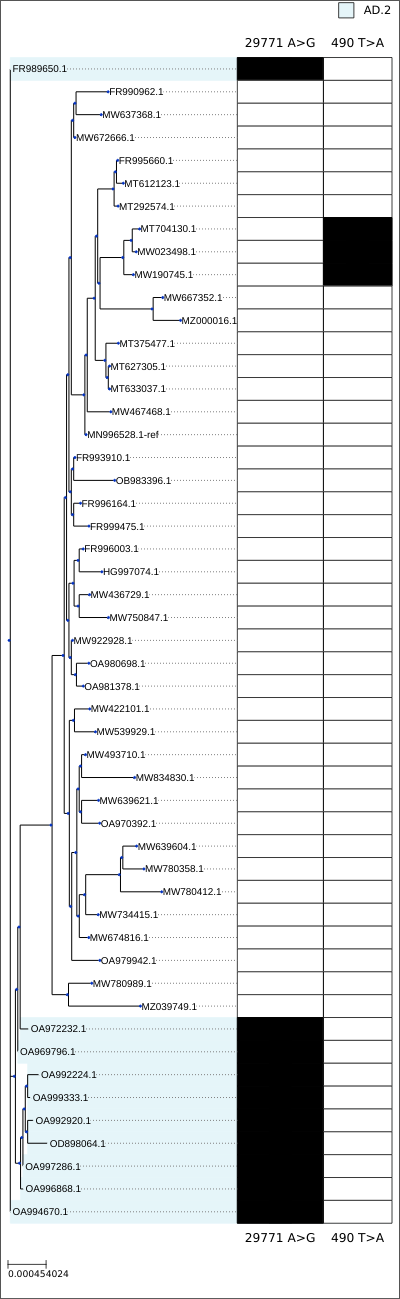

In [66]:
q.tree_styler()\
    .annotate(q.hasa('MN996528.1:29771:A:G'), label='29771 A>G')\
    .annotate(q.hasa('MN996528.1:490:T:A'), label='490 T>A')\
    .highlight(q.isa('AD.2', kind='dataframe', isa_column='Pangolin'), legend_label='AD.2')\
    .render(w=400)

### 4.2.8. Show summary of mutations for a lineage

Let's show a summary of mutations for lineage `AD.2`.

In [69]:
q.isa('AD.2', kind='dataframe', isa_column='Pangolin').summary_features().head(3)

,Sequence,Position,Deletion,Insertion,Count
Mutation,,,,,
MN996528.1:241:C:T,MN996528.1,241,C,T,10
MN996528.1:593:C:T,MN996528.1,593,C,T,1
MN996528.1:1163:A:T,MN996528.1,1163,A,T,10


### 4.2.9. Unique features

We can also produce a set of unique features found only in lineage `AD.2` (out of everything in our index).

In [73]:
s = q.isa('AD.2', kind='dataframe', isa_column='Pangolin').tofeaturesset(selection='unique')
s

{'MN996528.1:10793:G:T',
 'MN996528.1:1163:A:T',
 'MN996528.1:1288:C:T',
 'MN996528.1:14202:G:T',
 'MN996528.1:18078:G:A',
 'MN996528.1:19017:C:T',
 'MN996528.1:19542:G:T',
 'MN996528.1:19718:C:T',
 'MN996528.1:21364:C:T',
 'MN996528.1:2189:C:T',
 'MN996528.1:22388:C:T',
 'MN996528.1:23248:C:T',
 'MN996528.1:25157:G:T',
 'MN996528.1:25346:G:A',
 'MN996528.1:26060:C:T',
 'MN996528.1:26456:C:T',
 'MN996528.1:27455:A:G',
 'MN996528.1:28453:C:T',
 'MN996528.1:28903:G:T',
 'MN996528.1:29017:G:A',
 'MN996528.1:29227:G:T',
 'MN996528.1:29466:C:T',
 'MN996528.1:29771:A:G',
 'MN996528.1:3256:T:C',
 'MN996528.1:5622:C:T',
 'MN996528.1:593:C:T',
 'MN996528.1:6788:T:C',
 'MN996528.1:8612:G:T',
 'MN996528.1:8917:C:T'}

We can also see that `MN996528.1:29771:A:G` is in this unique set, as shown in the tree (**4.2.7**).

In [74]:
'MN996528.1:29771:A:G' in s

True

### 4.2.10. Build and visualize kmer tree

We can also build a kmer-based tree (using the sourmash sketches). We can then visualize this tree and display similar to the mutation-based phylogenetic tree.

First we create a query and build a kmer-tree with it.

In [78]:
kq = db.samples_query().join(metadata_df, sample_names_column='Accession').build_tree(kind='kmer', kmer_size=51)
kq

<KmerTreeSamplesQuery[100% (50/50) samples]>

Now let's visualize this tree, showing the same mutations and lineage information as in (**4.2.7**).

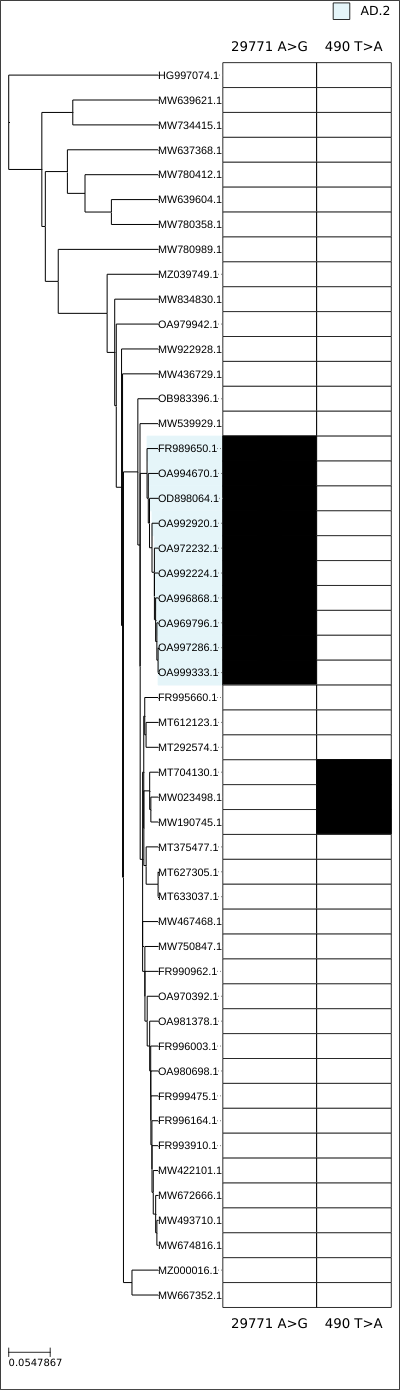

In [79]:
kq.tree_styler()\
    .annotate(kq.hasa('MN996528.1:29771:A:G'), label='29771 A>G')\
    .annotate(kq.hasa('MN996528.1:490:T:A'), label='490 T>A')\
    .highlight(kq.isa('AD.2', kind='dataframe', isa_column='Pangolin'), legend_label='AD.2')\
    .render(w=400)

*Note: with SARS-CoV-2 being such a small genome where most samples are very closely-related the kmer-based trees will likely not cluster genomes similarly to mutation-based trees (mutation-based trees would be prefered here, but kmer trees may be prefered for more distantly-related genomes).*

# 5. Finished

You are now finished with this tutorial. Awesome :). Please feel free to leave issues on GitHub if you encounter any issues.